EuroSat Dataset found here

https://github.com/phelber/EuroSAT

In [1]:
# install these if using new compute

# pip install seaborn
# pip install scikit_learn
# pip install tensorflow-addons
#%pip install transformers
#%pip install tf-keras
#%pip install keras-cv
#%pip install tensorflow-hub
#%pip install tensorflow

#%pip uninstall tensorflow

In [2]:
# data manipulation libraries
import pandas as pd
import numpy as np
import copy
import os
import datetime

# imports visualisation libraries
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import tensorflow as tf

# trying to suppress warnings
tf.get_logger().setLevel('ERROR')

# Suppress annoying warnings
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR) # supress tensorflow warnings

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import keras
from keras.utils import image_dataset_from_directory
from keras import layers, models, regularizers
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import load_model


from tensorflow.keras.applications.resnet50 import preprocess_input

# take this off if using GPU
# Ensure no GPUs are visible to TensorFlow
# tf.config.set_visible_devices([], 'GPU')  # Disable GPU
# tf.config.experimental.set_visible_devices([], 'GPU')

# evaluation
from sklearn.metrics import confusion_matrix,  f1_score, accuracy_score

# everything works so supressing all warnings for final run
import warnings
warnings.filterwarnings('ignore')

2025-03-22 13:38:03.723444: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-22 13:38:06.414797: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-22 13:38:10.500433: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2025-03-22 13:38:10.500549: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [3]:
import tensorflow as tf
print(tf.__version__)

2.10.0


In [4]:
# Function for importing data

# This splits into train/test/val without data leakage

Changed this to 80/10/10 later in the notebook

In [5]:
%%time
# function to import the data
# https://keras.io/examples/vision/image_classification_from_scratch/

def import_data(image_size, batch_size, colour, base_dir):
    # 70/30 split
    full_val_test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.3,  # 30% of data for validation and test
        subset='validation',
        color_mode=colour,
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
    )
    
    # further split the 30% reserved dataset into validation (15%) and test (15%)
    val_size = int(0.5 * tf.data.experimental.cardinality(full_val_test_ds).numpy())
    
    # val set set half of 30%
    val_ds = full_val_test_ds.take(val_size)
    
    # test set is remaining half of 30%
    test_ds = full_val_test_ds.skip(val_size)
    
    # train set - 70%
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.3,
        subset='training',
        color_mode=colour,
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
    )
    
    return train_ds, val_ds, test_ds

base_dir = r'/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat_RGB'
image_size = (256, 256)
batch_size = 64
colour = 'rgb'
train_ds, val_ds, test_ds = import_data(image_size, batch_size, colour, base_dir)

Found 27000 files belonging to 10 classes.
Using 8100 files for validation.
Found 27000 files belonging to 10 classes.
Using 18900 files for training.
CPU times: user 1.43 s, sys: 38.2 s, total: 39.7 s
Wall time: 9.52 s


2025-03-22 13:38:22.260098: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory
2025-03-22 13:38:22.260127: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-03-22 13:38:22.280709: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [6]:
# get class names for using later
class_names = train_ds.class_names

# sample further

#### for testing purposes

Using this to test on a small subset. Change the testing variable to True if you want so sample down

In [7]:
def sample_dataset(dataset, fraction):
    # calculates total number of elements in the dataset
    dataset_size = tf.data.experimental.cardinality(dataset).numpy()
    
    # calculates no. of samples based on fraction given
    sample_size = max(1, int(dataset_size * fraction))
    
    # gets sample
    sampled_dataset = dataset.take(sample_size)
    return sampled_dataset

In [8]:
testing = False # change testing to True if want to run in test mode

In [9]:
if testing:
    train_ds = sample_dataset(train_ds, 0.05)
    val_ds = sample_dataset(val_ds, 0.05)
    test_ds = sample_dataset(val_ds, 0.05)
else:
    pass

# Functions for evaluation

A lot of this was from NN coursework which in turn was basewd on the chollett book used as the text book for the course

### Charts for showing training validation and loss

In [10]:
# The code for the charts is based on code from pp74-75 from Deep Learning with Python [8].
# function to create charts for training and validation loss/accuracy
# based on code from p75 DLWP
def loss_accuracy_charts(hist):
    # gets loss/accuracy data from history object
    loss = hist.history['loss']
    val_loss = hist.history['val_loss']
    accuracy = hist.history['accuracy']
    val_accuracy = hist.history['val_accuracy']

    epochs = range(1, len(loss) + 1) # this gets numbers of epochs to use in plotting (on the x axis)

    plt.figure(figsize=(12, 5))

    # plot training/validation loss
    plt.subplot(1, 2, 1)  # plots in col 1
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # plot training/validation accuracy
    plt.subplot(1, 2, 2)  # plots in col 2
    plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
    plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [11]:
#### function to get y_true and y_pred

def get_y_vals(current_model, test_dataset):
    y_true = []
    y_pred = []
    
    for images, labels in test_dataset:
        # append true labels
        y_true.extend(labels.numpy())
        
        # get predictions
        predictions = current_model.predict(images) # https://keras.io/api/models/model_training_apis/
        
        # convert preds back to class labels
        y_pred.extend(np.argmax(predictions, axis=1))
    
    # convert y_true to a flat list
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    return y_true, y_pred

In [12]:
#### function for evaluation of results, gets loss, accuracy from results and calculates F1
def model_results(res, y_true, y_pred):
    print(f"Loss:{res[0]}")
    print(f"Accuracy:{res[1]}")
    print(f"F1 (macro): {f1_score(y_true, y_pred, average='macro')}")
    print(f"F1 (weighted): {f1_score(y_true, y_pred, average='weighted')}")

In [13]:
# function for confusion matrix

def conf_mat_func(y_true,y_pred):
    conf_matrix = confusion_matrix(y_true, y_pred) # create confusion matrix data
    # plot the confusion matrix
    plt.figure(figsize=(6, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title('Confusion Matrix')
    plt.show()

In [14]:
# brings all functions together to evaluate

def evaluation(current_model,test_dataset,res, history):
    y_true, y_pred = get_y_vals(current_model,test_dataset)
    
    model_results(res,y_true,y_pred)
    
    loss_accuracy_charts(history)
    
    conf_mat_func(y_true,y_pred)

# Training

In [15]:
### Configure the data for performance

In [16]:
# applies reschaling
train_ds = train_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))
val_ds = val_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))
test_ds = test_ds.map(lambda x, y: (layers.Rescaling(1./255)(x), y))

### Changed shuffle to 27000 at model 7

In [17]:
# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(27000).prefetch(buffer_size=AUTOTUNE) # change this up to the total amount of images in the dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Model 3

Adds augmentation, rescaling L2 reg and dropouts

- Loss:1.5682765245437622
- Accuracy:0.4373141825199127
- F1 (macro): 0.405075150374432
- F1 (weighted): 0.4145316670891367

Model was overfitting and stagnates around 45% accuracy. Doesn't look like it will improve much beyond 10 epochs

In [18]:
# creates augmentation layer
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),  # flips horizontally and vertically
    layers.RandomRotation(0.2),  # rotates randomly by 20%
    layers.RandomZoom(0.2),  # random zoom up to 20%
    layers.RandomContrast(0.1),  # slight contrast changes
    layers.RandomTranslation(0.1, 0.1)  # random translate up to 10%
])

# define architecture
model = models.Sequential([
    data_augmentation, # adds in aug layer
    
    # conv layers with L2 regularization
    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D(2, 2),
    
    # dropout Layer
    layers.Dropout(0.5),
    
    # flatten Layer
    layers.Flatten(),
    
    # fully connected layers with dropout and L2
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.5),
    
    # output layer - 10 classes Eurosat has 10 classes)
    layers.Dense(10, activation='softmax')
])

# complile model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',  # uses sparse categorical crossentropy
              metrics=['accuracy'])

# summary of the model - to use for checking architecture (if needed later)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 128)      

In [19]:
%%time
# fit the model
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/10
296/296 [==============================] - 373s 1s/step - loss: 2.1896 - accuracy: 0.2186 - val_loss: 1.7856 - val_accuracy: 0.3524
Epoch 2/10
296/296 [==============================] - 341s 1s/step - loss: 1.8059 - accuracy: 0.3454 - val_loss: 1.6050 - val_accuracy: 0.4705
Epoch 3/10
296/296 [==============================] - 341s 1s/step - loss: 1.6513 - accuracy: 0.4399 - val_loss: 1.4912 - val_accuracy: 0.5231
Epoch 4/10
296/296 [==============================] - 340s 1s/step - loss: 1.5826 - accuracy: 0.4784 - val_loss: 1.4087 - val_accuracy: 0.5508
Epoch 5/10
296/296 [==============================] - 340s 1s/step - loss: 1.5287 - accuracy: 0.5019 - val_loss: 1.3530 - val_accuracy: 0.6009
Epoch 6/10
296/296 [==============================] - 340s 1s/step - loss:

2025-03-22 13:38:41.305884: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 104 of 27000
2025-03-22 13:38:51.303657: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 222 of 27000
2025-03-22 13:38:56.875782: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:415] Shuffle buffer filled.


2/2 [==============================] - 0s 15ms/step
Loss:1.228103756904602
Accuracy:0.6408554315567017
F1 (macro): 0.6141693673881752
F1 (weighted): 0.6196412113644777


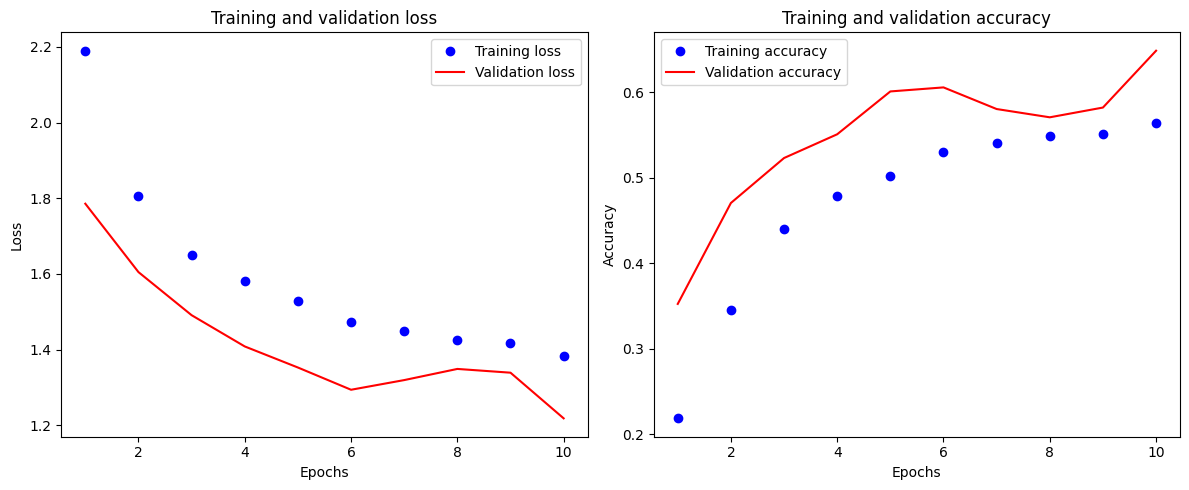

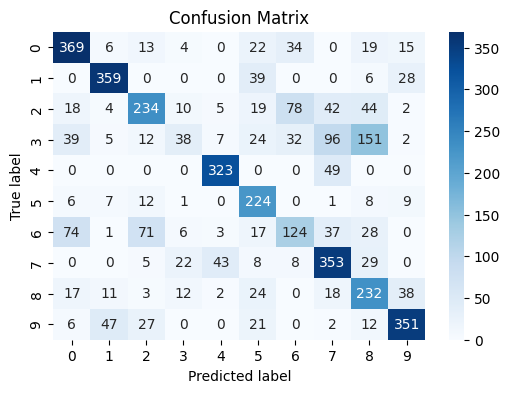

In [20]:
# evaluate the model
results = model.evaluate(test_ds)

evaluation(model,test_ds,results,history)

# Model 4

If this works might need to try them all indivisually, maybe with a reduced dataset

- Adding more L2
- reduce learning rate
- more dropout
- early stopping
- batch normalisation

In [21]:
## take comments off to make cleaner - see above if need comments

In [22]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical", input_shape=(256, 256, 3)),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])


model = models.Sequential([

    data_augmentation,

    layers.Conv2D(32, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2, 2),
    
    layers.Conv2D(128, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(), 
    layers.MaxPooling2D(2, 2),
    
    layers.Dropout(0.6),
    
    layers.Flatten(),
    
    layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(), 
    layers.Dropout(0.6),
    
    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    layers.BatchNormalization(), 
    layers.Dropout(0.6),
    
    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 254, 254, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 batch_normalization_1 (Batc  (None, 125, 125, 64)    

In [23]:
# fit the model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # add early stopping callback

epochs = 50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping] #  adds early stopping callback
)

Epoch 1/50
296/296 [==============================] - 466s 2s/step - loss: 6.5754 - accuracy: 0.3778 - val_loss: 6.6317 - val_accuracy: 0.2054
Epoch 2/50
296/296 [==============================] - 461s 2s/step - loss: 5.4630 - accuracy: 0.5009 - val_loss: 4.9260 - val_accuracy: 0.5367
Epoch 3/50
296/296 [==============================] - 461s 2s/step - loss: 4.7158 - accuracy: 0.5471 - val_loss: 3.9453 - val_accuracy: 0.7014
Epoch 4/50
296/296 [==============================] - 461s 2s/step - loss: 4.1237 - accuracy: 0.5782 - val_loss: 3.5042 - val_accuracy: 0.7123
Epoch 5/50
296/296 [==============================] - 461s 2s/step - loss: 3.6819 - accuracy: 0.6010 - val_loss: 3.1909 - val_accuracy: 0.6947
Epoch 6/50
296/296 [==============================] - 461s 2s/step - loss: 3.3

2/2 [==============================] - 0s 21ms/step
Loss:1.7177183628082275
Accuracy:0.8534906506538391
F1 (macro): 0.8460946063715153
F1 (weighted): 0.8516135782392437


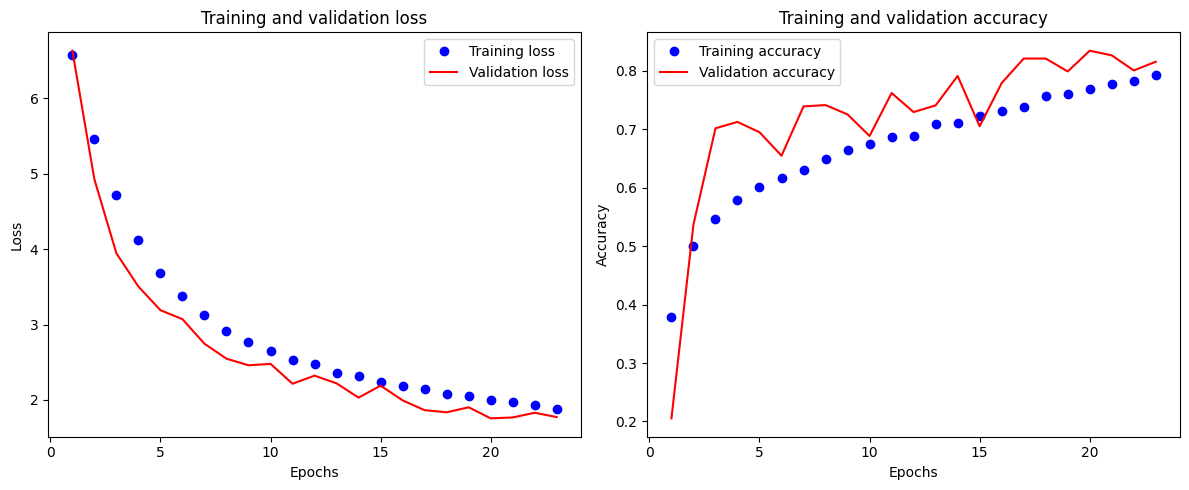

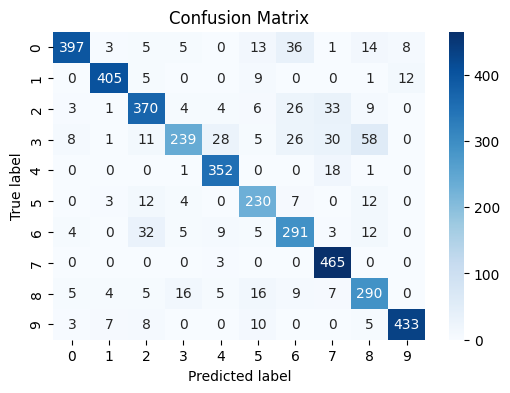

In [24]:
# evaluate the model
results = model.evaluate(test_ds)

evaluation(model,test_ds,results,history)

In [25]:
# #save the model
# model.save('model_4.keras')

# Model 5

#### Resnt-50 transfer learning

In [26]:
# https://www.tensorflow.org/tutorials/images/transfer_learning
# https://medium.com/@bravinwasike18/building-a-deep-learning-model-with-keras-and-resnet-50-9dd6f4eb3351
# DWLP pp143-159

data_augmentation = keras.Sequential([
     layers.RandomFlip("horizontal_and_vertical"),
     layers.RandomRotation(0.2),
     layers.RandomZoom(0.2),
     layers.RandomContrast(0.1),
     layers.RandomTranslation(0.1, 0.1)
 ])

 # use the resnet model

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3)) # load model

resnet_model.trainable = False


 # defines architecture - uses ResNet
model = models.Sequential([
layers.Input(shape=(256, 256, 3)),
     data_augmentation,
     resnet_model,
     layers.GlobalAveragePooling2D(),
     layers.Dense(256, activation='relu'),
     layers.Dropout(0.5),
     layers.Dense(10, activation='softmax')  # output layer - 10 classes
 ])

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

 # compile model
model.compile(optimizer=optimizer,
               loss='sparse_categorical_crossentropy',
               metrics=['accuracy'])

model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense_6 (Dense)             (None, 256)               524544    
                                                                 
 dropout_6 (Dropout)         (None, 256)               0         
                                                                 
 dense_7 (Dense)             (None, 10)                2570      
                                                      

In [27]:
%%time
# fit the model

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True) # add early stopping callback

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('resnet_model_5_best.keras', save_best_only=True)

epochs = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, model_checkpoint] #  adds early stopping callback
)

Epoch 1/30
296/296 [==============================] - 472s 2s/step - loss: 2.3714 - accuracy: 0.1313 - val_loss: 2.2455 - val_accuracy: 0.2091
Epoch 2/30
296/296 [==============================] - 466s 2s/step - loss: 2.2340 - accuracy: 0.1888 - val_loss: 2.1953 - val_accuracy: 0.2274
Epoch 3/30
296/296 [==============================] - 465s 2s/step - loss: 2.1954 - accuracy: 0.2004 - val_loss: 2.1472 - val_accuracy: 0.2530
Epoch 4/30
296/296 [==============================] - 465s 2s/step - loss: 2.1474 - accuracy: 0.2130 - val_loss: 2.0965 - val_accuracy: 0.2701
Epoch 5/30
296/296 [==============================] - 465s 2s/step - loss: 2.1036 - accuracy: 0.2229 - val_loss: 2.0585 - val_accuracy: 0.2860
Epoch 6/30
296/296 [==============================] - 465s 2s/step - loss: 2.0

2/2 [==============================] - 1s 108ms/step
Loss:1.6972894668579102
Accuracy:0.3485742509365082
F1 (macro): 0.2583168120005396
F1 (weighted): 0.2736896469854505


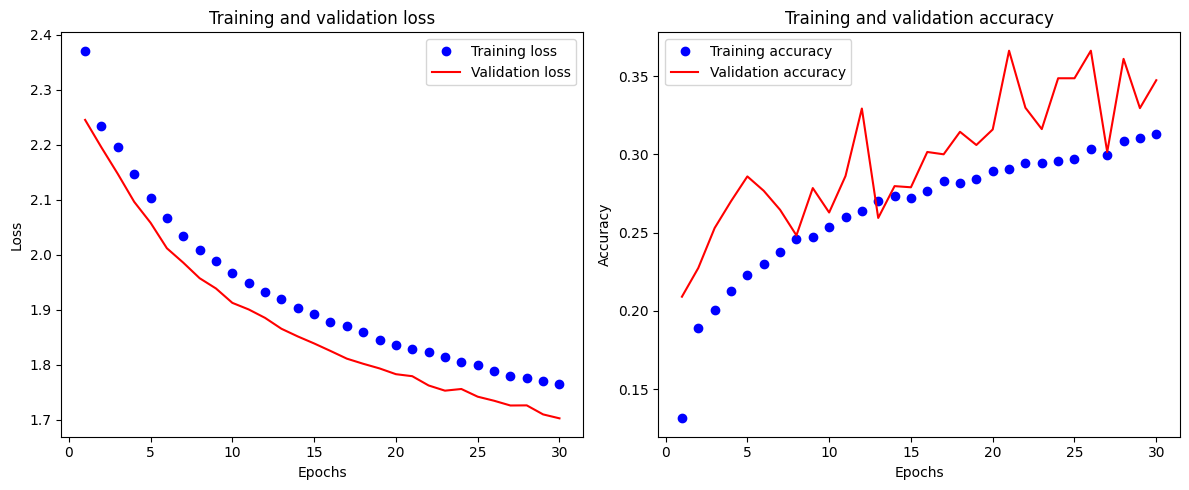

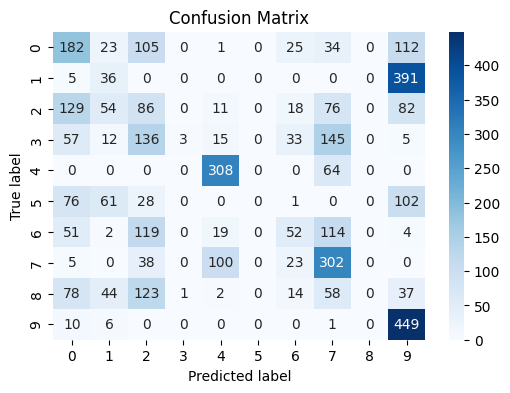

In [28]:
# evaluate the model
results = model.evaluate(test_ds)

evaluation(model,test_ds,results,history)

# Model 6

### Resnet with fine tuning

In [29]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.1, 0.1)
])

# load ResNet50 and freeze all layers
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet_model.trainable = False  # this freezes all layers

model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    data_augmentation,
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

# compiles with a higher learning rate for initial training
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callbakcs with .keras format
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint_phase1 = tf.keras.callbacks.ModelCheckpoint('resnet_model_6_phase1_best.keras', save_best_only=True)

# phase 1 - trains the Model with frozen ResNet-50 layers
history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  # Train for a few epochs
    callbacks=[early_stopping, model_checkpoint_phase1]
)

# phase 2 unfreezes layers and fine-tune the model

# unfeezes the last few layers
resnet_model.trainable = True
for layer in resnet_model.layers[:-10]:  # keeps all but last 10 layers frozen
    layer.trainable = False

# compiles with a lower learning rate for fine-tuning
fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=fine_tune_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callback for Phase 2 with .keras format
model_checkpoint_fine_tune = tf.keras.callbacks.ModelCheckpoint('resnet_model_6_fine_tune_best.keras', save_best_only=True)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,  
    callbacks=[early_stopping, model_checkpoint_fine_tune]
)

Epoch 1/10
296/296 [==============================] - 473s 2s/step - loss: 1.7187 - accuracy: 0.3830 - val_loss: 2.4067 - val_accuracy: 0.2426
Epoch 2/10
296/296 [==============================] - 467s 2s/step - loss: 1.4355 - accuracy: 0.4769 - val_loss: 1.4845 - val_accuracy: 0.4990
Epoch 3/10
296/296 [==============================] - 465s 2s/step - loss: 1.3444 - accuracy: 0.5110 - val_loss: 1.2018 - val_accuracy: 0.5863
Epoch 4/10
296/296 [==============================] - 466s 2s/step - loss: 1.2880 - accuracy: 0.5358 - val_loss: 1.1184 - val_accuracy: 0.6166
Epoch 5/10
296/296 [==============================] - 465s 2s/step - loss: 1.2441 - accuracy: 0.5434 - val_loss: 1.0800 - val_accuracy: 0.6342
Epoch 6/10
296/296 [==============================] - 466s 2s/step - loss: 1.2

2/2 [==============================] - 1s 108ms/step
Loss:1.4968010187149048
Accuracy:0.4653392434120178
F1 (macro): 0.35908756210374293
F1 (weighted): 0.3817729438578131


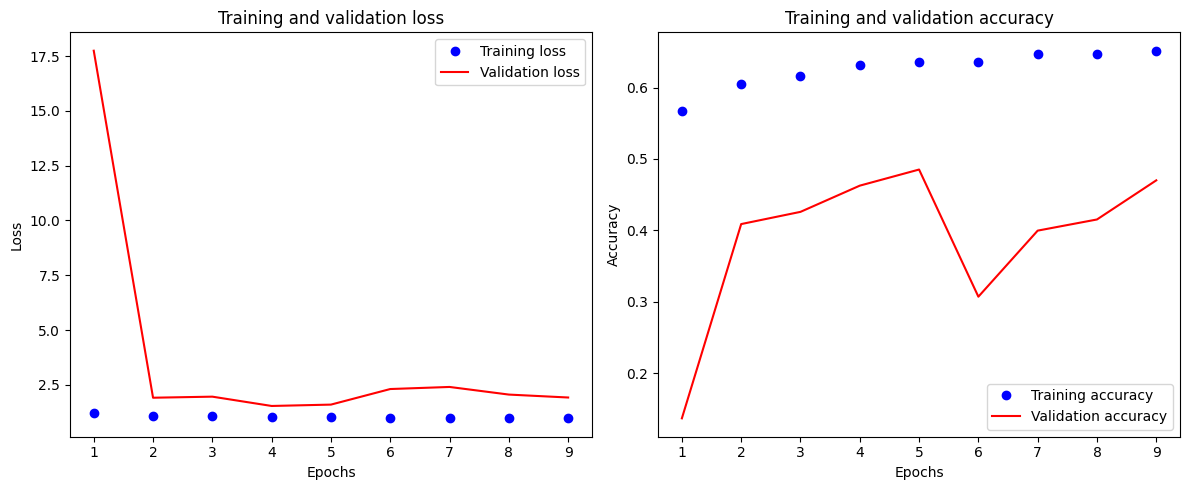

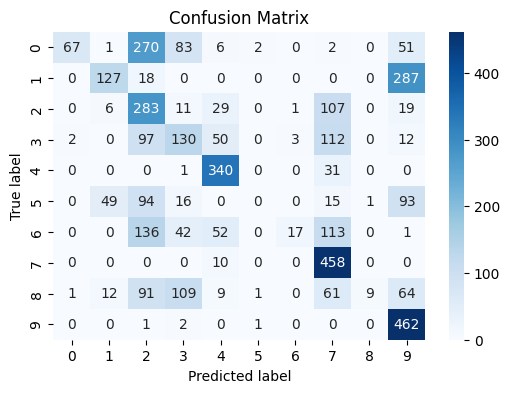

In [30]:
# evaluate the model
results = model.evaluate(test_ds)

evaluation(model,test_ds,results,fine_tune_history)

In [31]:
# ## you would load the models like this

# model_phase1 = tf.keras.models.load_model('best_resnet_model_phase1.keras')
# model_fine_tune = tf.keras.models.load_model('best_resnet_model_fine_tune.keras')

# Model 7

#### Fine tuning with changes

- Reduced rotation on augmentation
- Added another batch normalisation
- ReduceLROnPlateau - add more stability
- adjusted to keep more layers frozen inititally
-- add l2 regulariser

Results

- Loss:0.7524049878120422
- Accuracy:0.7605702877044678
- F1 (macro): 0.7399202919714994
- F1 (weighted): 0.7539229201504464


In [32]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomTranslation(0.05, 0.05)
])

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
resnet_model.trainable = False

model = models.Sequential([
    layers.Input(shape=(256, 256, 3)),
    data_augmentation,
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    layers.Dropout(0.5),
    layers.Dense(10, activation='softmax')
])

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
model_checkpoint_phase1 = ModelCheckpoint('resnet_model_7_phase1_best.keras', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)

history_phase1 = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint_phase1, reduce_lr]
)

resnet_model.trainable = True
for layer in resnet_model.layers[:-20]: # gradual unfreezing
    layer.trainable = False


fine_tune_optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=fine_tune_optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_checkpoint_fine_tune = ModelCheckpoint('resnet_model_7_fine_tune_best.keras', save_best_only=True)

fine_tune_history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=25,
    callbacks=[early_stopping, model_checkpoint_fine_tune, reduce_lr]
)

Epoch 1/25
296/296 [==============================] - 472s 2s/step - loss: 5.0671 - accuracy: 0.1648 - val_loss: 3.8071 - val_accuracy: 0.3078 - lr: 1.0000e-04
Epoch 2/25
296/296 [==============================] - 464s 2s/step - loss: 3.3660 - accuracy: 0.2128 - val_loss: 2.9733 - val_accuracy: 0.2924 - lr: 1.0000e-04
Epoch 3/25
296/296 [==============================] - 464s 2s/step - loss: 2.9271 - accuracy: 0.2326 - val_loss: 2.6752 - val_accuracy: 0.3021 - lr: 1.0000e-04
Epoch 4/25
296/296 [==============================] - 464s 2s/step - loss: 2.7150 - accuracy: 0.2503 - val_loss: 2.5166 - val_accuracy: 0.3194 - lr: 1.0000e-04
Epoch 5/25
296/296 [==============================] - 463s 2s/step - loss: 2.5667 - accuracy: 0.2604 - val_loss: 2.3954 - val_accuracy: 0.3041 - lr: 1.0000e-04
Epoch 6/25
296/296 [==============================] - 464s 2s/step - loss: 2.4

2/2 [==============================] - 1s 110ms/step
Loss:0.9230538010597229
Accuracy:0.6838741302490234
F1 (macro): 0.6631893735134691
F1 (weighted): 0.6742784884731416


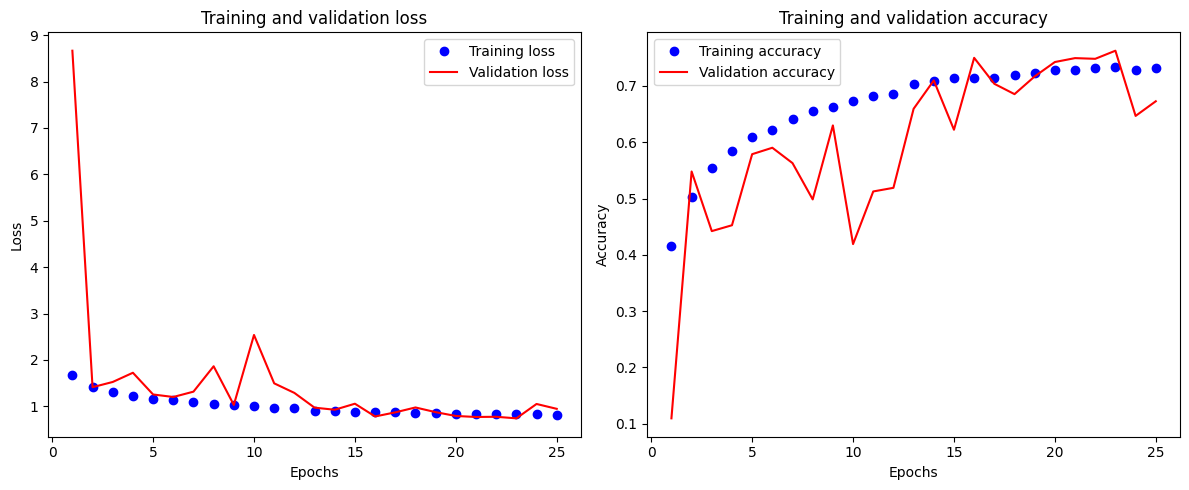

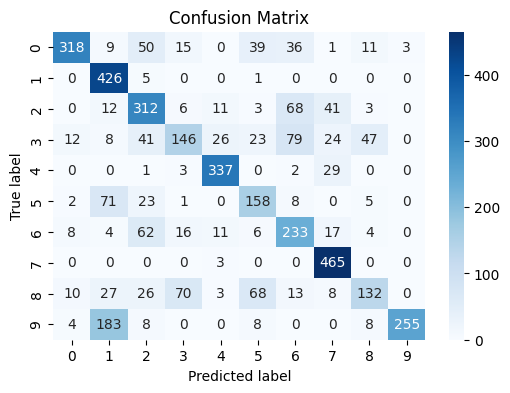

In [33]:
# evaluate the model
results = model.evaluate(test_ds)

evaluation(model,test_ds,results,fine_tune_history)

# Model 9

### changed methodology

### used similar methods from this paper

It makes sure the data is preprocessed properly in line with how ResNet 50 was trained on imagenet

https://www.techscience.com/RIG/v33n1/55498

https://github.com/sumn2u/LULC-Mapping/blob/main/Classification_of_LULC_using_ResNet50_using_EuroSAT_15_Epoch_.ipynb



In [34]:
# loads and preprocesses
def import_data(image_size, batch_size, base_dir, colour):
    # uses 70/30 split
    full_val_test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.3,
        subset='validation',
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
        color_mode = colour
    )
    
    # splits further 15/15 val and test sets
    val_size = int(0.5 * tf.data.experimental.cardinality(full_val_test_ds).numpy())
    val_ds = full_val_test_ds.take(val_size)
    test_ds = full_val_test_ds.skip(val_size)
    
    # train = 70%
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.3,
        subset='training',
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
        color_mode = colour
    )
    

    # preprocesses - using Preporcess_input fuinction in line with Resnet50 preprocessing requirements
    train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))
    val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
    test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))

    return train_ds, val_ds, test_ds

# https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(27000).prefetch(buffer_size=AUTOTUNE) # changed this up to the total amount of images in the dataset
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

# directory used
base_dir = r'/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat_RGB'
image_size = (224, 224)
batch_size = 64
colour = 'rgb'
train_ds, val_ds, test_ds = import_data(image_size, batch_size, base_dir, colour)

Found 27000 files belonging to 10 classes.
Using 8100 files for validation.
Found 27000 files belonging to 10 classes.
Using 18900 files for training.


In [35]:
# sample data for testing
if testing:
    train_ds = sample_dataset(train_ds, 0.05)
    val_ds = sample_dataset(val_ds, 0.05)
    test_ds = sample_dataset(val_ds, 0.05)
else:
    pass

Results

64/64 ━━━━━━━━━━━━━━━━━━━━ 18s 196ms/step - accuracy: 0.9508 - loss: 0.145
Test Loss: 0.152729332447052, Test Accuracy: 0.9483776092529297

In [36]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False  # freeze all layers


# model architecture

model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),  #no L2
    layers.Dense(10, activation='softmax')
])

#low learing rate initially
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# callbacks - early stopping, stops if doesnt improve after 3 epochs
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_model_9_best.keras', save_best_only=True)

# trains model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=15,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/15
296/296 [==============================] - 347s 1s/step - loss: 1.4435 - accuracy: 0.5542 - val_loss: 0.8163 - val_accuracy: 0.7986
Epoch 2/15
296/296 [==============================] - 344s 1s/step - loss: 0.6149 - accuracy: 0.8260 - val_loss: 0.4890 - val_accuracy: 0.8576
Epoch 3/15
296/296 [==============================] - 343s 1s/step - loss: 0.4239 - accuracy: 0.8775 - val_loss: 0.3738 - val_accuracy: 0.8914
Epoch 4/15
296/296 [==============================] - 342s 1s/step - loss: 0.3385 - accuracy: 0.9005 - val_loss: 0.3087 - val_accuracy: 0.9058
Epoch 5/15
296/296 [==============================] - 341s 1s/step - loss: 0.2843 - accuracy: 0.9177 - val_loss: 0.2733 - val_accuracy: 0.9147
Epoch 6/15
296/296 [==============================] - 343s 1s/step - l

In [37]:
# Evaluate the model on the test set
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")


64/64 [==============================] - 67s 946ms/step - loss: 0.1480 - accuracy: 0.9508
Test Loss: 0.14797326922416687, Test Accuracy: 0.9508357644081116


2/2 [==============================] - 1s 87ms/step
Loss:0.14879024028778076
Accuracy:0.9503441452980042
F1 (macro): 0.9488683225111083
F1 (weighted): 0.951214773956808


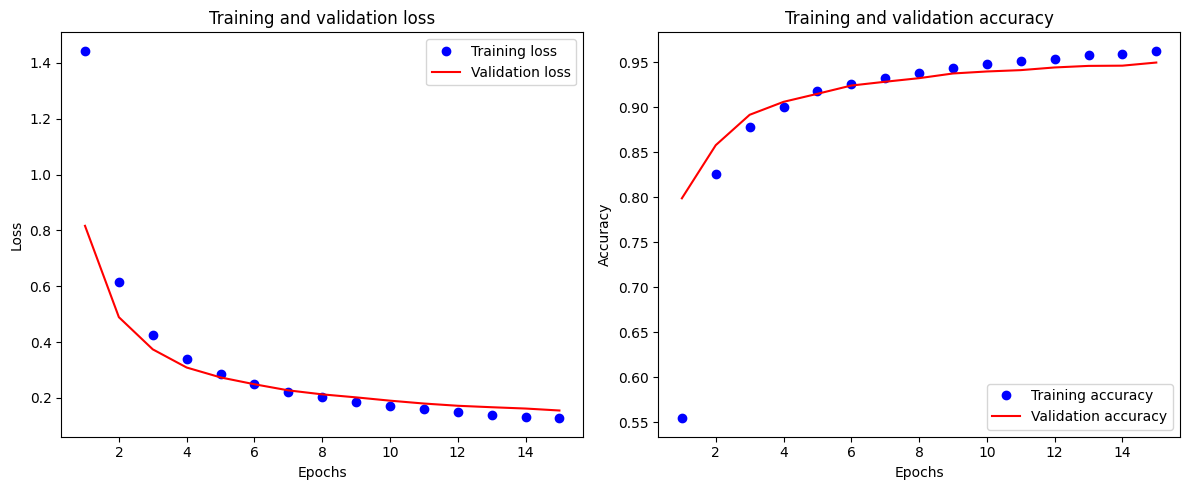

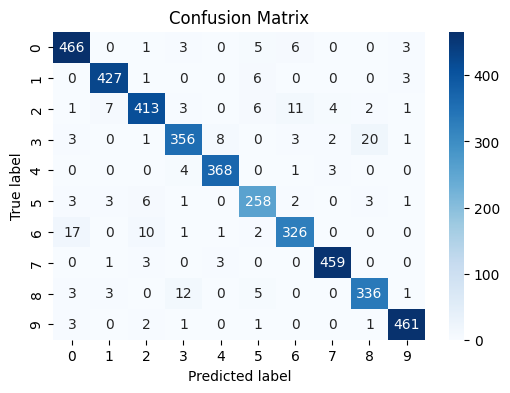

In [38]:
# evaluate the model
results = model.evaluate(test_ds)

evaluation(model,test_ds,results,history)

# Model 9 v2

added more epochs. Also second reason for running again is it didnt output any charts




In [39]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False


model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')
])

optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_model_9_v2_best.keras', save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
296/296 [==============================] - 345s 1s/step - loss: 1.5119 - accuracy: 0.5111 - val_loss: 0.8483 - val_accuracy: 0.7847
Epoch 2/20
296/296 [==============================] - 342s 1s/step - loss: 0.6468 - accuracy: 0.8131 - val_loss: 0.5047 - val_accuracy: 0.8611
Epoch 3/20
296/296 [==============================] - 341s 1s/step - loss: 0.4440 - accuracy: 0.8710 - val_loss: 0.3811 - val_accuracy: 0.8899
Epoch 4/20
296/296 [==============================] - 343s 1s/step - loss: 0.3496 - accuracy: 0.8959 - val_loss: 0.3173 - val_accuracy: 0.9082
Epoch 5/20
296/296 [==============================] - 342s 1s/step - loss: 0.2925 - accuracy: 0.9115 - val_loss: 0.2725 - val_accuracy: 0.9174
Epoch 6/20
296/296 [==============================] - 343s 1s/step - los

In [40]:
# Evaluate the model on the test set
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")


64/64 [==============================] - 66s 943ms/step - loss: 0.1315 - accuracy: 0.9575
Test Loss: 0.13151809573173523, Test Accuracy: 0.9574729800224304


2/2 [==============================] - 1s 90ms/step
Loss:0.13371160626411438
Accuracy:0.9564896821975708
F1 (macro): 0.9540886277999305
F1 (weighted): 0.9561907200526932


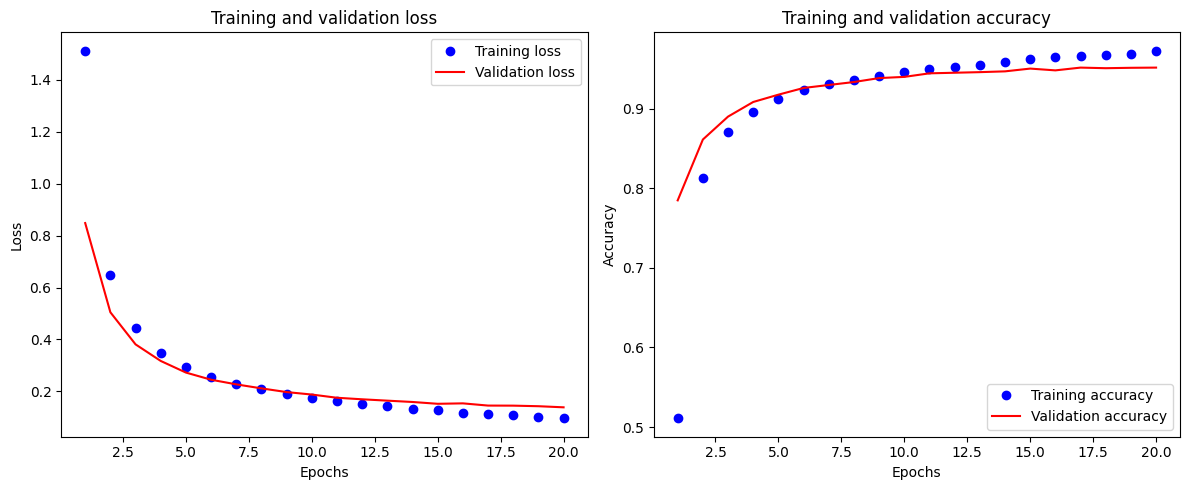

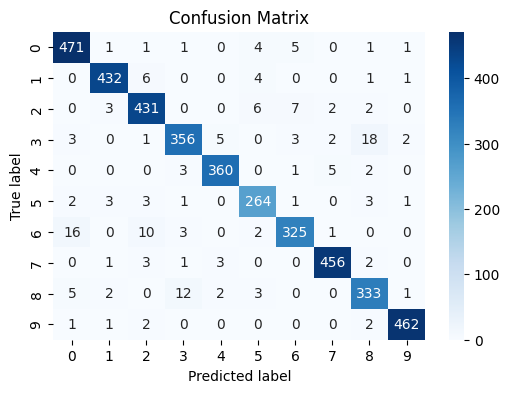

In [41]:
# evaluate the model
results = model.evaluate(test_ds)

evaluation(model,test_ds,results,history)

# Model 10v3

decrease learning rate and L2

changes train test split and add augmentation


43/43 ━━━━━━━━━━━━━━━━━━━━ 84s 2s/step - accuracy: 0.9531 - loss: 0.14
Test Loss: 0.1472080498933792, Test Accuracy: 0.9513274431228638

### Changed split to 80/10/10

In [42]:
def import_data(image_size, batch_size, base_dir, colour):
    # changes split to 80/20
    full_val_test_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='validation',
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
        color_mode=colour
    )
    
    # then splits further to 10% for val and 10% for test
    val_size = int(0.5 * tf.data.experimental.cardinality(full_val_test_ds).numpy())
    val_ds = full_val_test_ds.take(val_size)
    test_ds = full_val_test_ds.skip(val_size)
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
        base_dir,
        validation_split=0.2,
        subset='training',
        seed=321,
        shuffle=True,
        image_size=image_size,
        batch_size=batch_size,
        color_mode=colour
    )

    # data augmentation pipeline
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2, fill_mode='nearest'),
        layers.RandomBrightness(0.2),
        layers.RandomContrast(0.2),
        layers.RandomTranslation(0.1, 0.1, fill_mode='nearest'),
        layers.GaussianNoise(0.1)
    ])

    # train processing pipeline
    AUTOTUNE = tf.data.AUTOTUNE
    train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y))
    train_ds = train_ds.map(lambda x, y: (preprocess_input(x), y))  # normalises for ResNet50
    train_ds = train_ds.cache().shuffle(buffer_size=tf.data.experimental.cardinality(train_ds).numpy()).prefetch(buffer_size=AUTOTUNE)
    
    # val and test pipelines
    val_ds = val_ds.map(lambda x, y: (preprocess_input(x), y))
    test_ds = test_ds.map(lambda x, y: (preprocess_input(x), y))
    val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
    test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

    return train_ds, val_ds, test_ds


base_dir = r'/home/azureuser/cloudfiles/code/Users/richesmith/Eurosat_RGB'
image_size = (224, 224)
batch_size = 64
colour = 'rgb'
train_ds, val_ds, test_ds = import_data(image_size, batch_size, base_dir, colour)

Found 27000 files belonging to 10 classes.
Using 5400 files for validation.
Found 27000 files belonging to 10 classes.
Using 21600 files for training.


In [43]:
# sample data for testing
if testing:
    train_ds = sample_dataset(train_ds, 0.05)
    val_ds = sample_dataset(val_ds, 0.05)
    test_ds = sample_dataset(val_ds, 0.05)
else:
    pass

In [44]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),  # added L2 regularisation - decrease from last to try and stop overfitting
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-5))  # L2 again
])

# Adam default is 0.001
# this model decreases learning rate as overfitting previously. the model will take smaller steps when updating training weights
optimizer = Adam(learning_rate=1e-5)  # adjusted learning rate
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_model_10v3_best_L21e5_LR1e5_8020split.keras', save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,  # increased epochs to 50
    callbacks=[early_stopping, model_checkpoint]
)

# eval on the test set
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Epoch 1/50
338/338 [==============================] - 495s 1s/step - loss: 1.5907 - accuracy: 0.4862 - val_loss: 0.8356 - val_accuracy: 0.7656
Epoch 2/50
338/338 [==============================] - 357s 1s/step - loss: 0.7470 - accuracy: 0.7788 - val_loss: 0.5015 - val_accuracy: 0.8464
Epoch 3/50
338/338 [==============================] - 357s 1s/step - loss: 0.5303 - accuracy: 0.8432 - val_loss: 0.3907 - val_accuracy: 0.8713
Epoch 4/50
338/338 [==============================] - 358s 1s/step - loss: 0.4291 - accuracy: 0.8705 - val_loss: 0.3322 - val_accuracy: 0.8888
Epoch 5/50
338/338 [==============================] - 356s 1s/step - loss: 0.3686 - accuracy: 0.8882 - val_loss: 0.2970 - val_accuracy: 0.9010
Epoch 6/50
338/338 [==============================] - 357s 1s/step - los

2025-03-23 11:04:57.945471: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 21 of 338
2025-03-23 11:05:08.153114: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 47 of 338
2025-03-23 11:05:17.959002: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 72 of 338
2025-03-23 11:05:28.138141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 98 of 338
2025-03-23 11:05:37.942177: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 123 of 338
2025-03-23 11:05:48.116256: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 149 of 338
2025-03-23 11:05:58.007495: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (thi

43/43 [==============================] - 40s 929ms/step - loss: 0.1516 - accuracy: 0.9513
Test Loss: 0.1515820175409317, Test Accuracy: 0.9513274431228638
1/1 [==============================] - 1s 1s/step
Loss:0.1515820175409317
Accuracy:0.9513274431228638
F1 (macro): 0.9503930786933396
F1 (weighted): 0.951343687770529


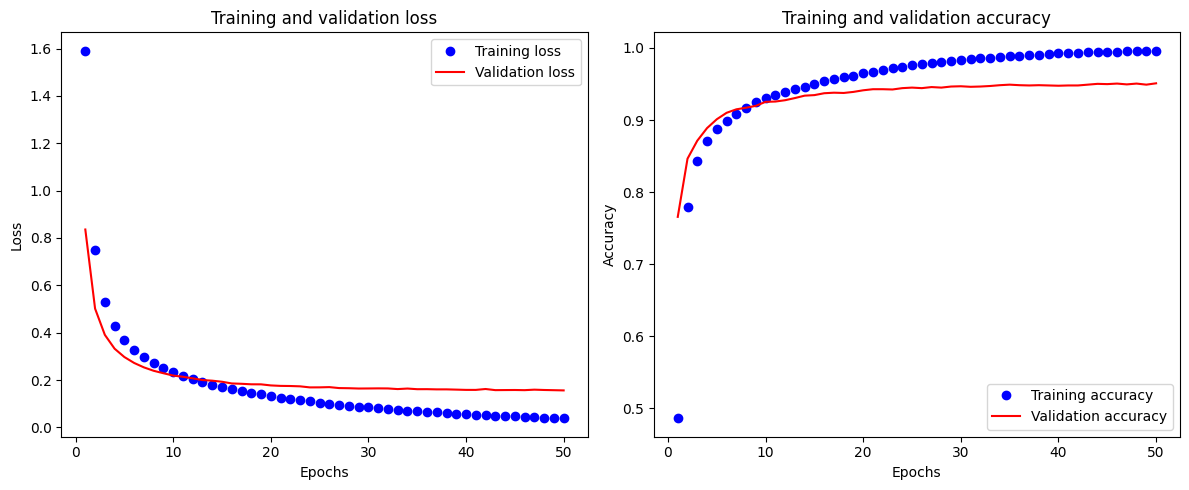

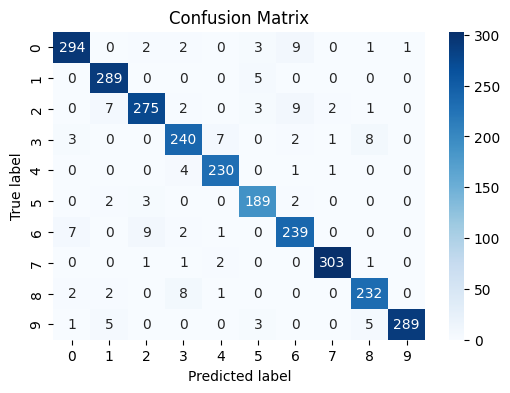

In [45]:
# # eval on the test set
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

evaluation(model,test_ds,results,history)

# Model 10v4

adjuest L2 regularisation 10 1e-6

The test result output didnt print correctly but got this from epoch output:

Epoch 43/50
338/338 ━━━━━━━━━━━━━━━━━━━━ 50s 148ms/step - accuracy: 0.9930 - loss: 0.0447 - val_accuracy: 0.9542 - val_loss: 0.139

In [46]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-6)),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-6))
])

# Adam default is 0.001
# this model decreases learning rate as overfitting previously. the model will take smaller steps when updating training weights
optimizer = Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_model_10v4_best_L21e6_LR1e5_8020split.keras', save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
338/338 [==============================] - 358s 1s/step - loss: 1.5460 - accuracy: 0.5082 - val_loss: 0.7825 - val_accuracy: 0.7794
Epoch 2/50
338/338 [==============================] - 357s 1s/step - loss: 0.7385 - accuracy: 0.7773 - val_loss: 0.4776 - val_accuracy: 0.8631
Epoch 3/50
338/338 [==============================] - 355s 1s/step - loss: 0.5308 - accuracy: 0.8397 - val_loss: 0.3719 - val_accuracy: 0.8850
Epoch 4/50
338/338 [==============================] - 356s 1s/step - loss: 0.4305 - accuracy: 0.8690 - val_loss: 0.3130 - val_accuracy: 0.9014
Epoch 5/50
338/338 [==============================] - 354s 1s/step - loss: 0.3691 - accuracy: 0.8848 - val_loss: 0.2772 - val_accuracy: 0.9100
Epoch 6/50
338/338 [==============================] - 354s 1s/step - loss: 0.3

43/43 [==============================] - 40s 920ms/step - loss: 0.1391 - accuracy: 0.9565
Test Loss: 0.13912256062030792, Test Accuracy: 0.9564896821975708
1/1 [==============================] - 1s 1s/step
Loss:0.13912256062030792
Accuracy:0.9564896821975708
F1 (macro): 0.9554735009399515
F1 (weighted): 0.9565276477583966


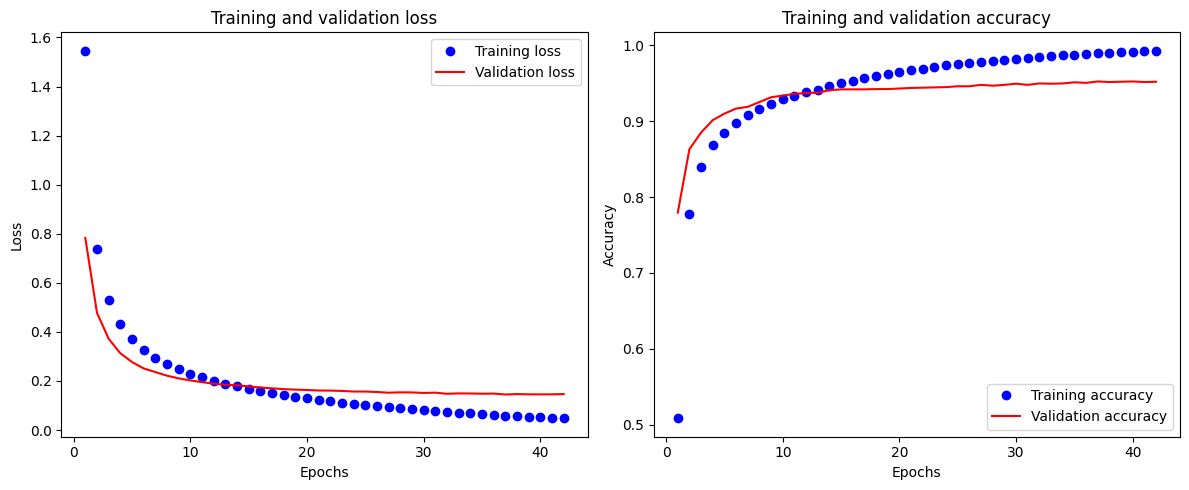

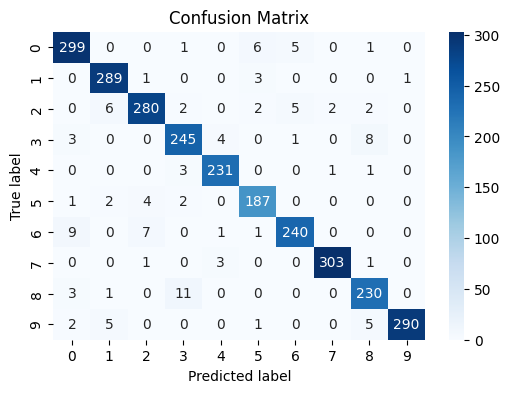

In [47]:
# # Evaluate the model on the test set
results = model.evaluate(test_ds)
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

evaluation(model,test_ds,results,history)

# -----------

# Model 10v8

No dropout

Learning rate decay added

Test Loss: 0.14179329574108124, Test Accuracy: 0.9568583965301514



In [49]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-5)),
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-5))
])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, decay_steps=1000, decay_rate=0.96
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_model_10v8_best_L21e5_LRDecay_8020split.keras', save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
338/338 [==============================] - 358s 1s/step - loss: 0.5248 - accuracy: 0.8305 - val_loss: 0.2056 - val_accuracy: 0.9301
Epoch 2/50
338/338 [==============================] - 356s 1s/step - loss: 0.2121 - accuracy: 0.9319 - val_loss: 0.1814 - val_accuracy: 0.9401
Epoch 3/50
338/338 [==============================] - 353s 1s/step - loss: 0.1464 - accuracy: 0.9563 - val_loss: 0.1705 - val_accuracy: 0.9472
Epoch 4/50
338/338 [==============================] - 355s 1s/step - loss: 0.1076 - accuracy: 0.9724 - val_loss: 0.1613 - val_accuracy: 0.9535
Epoch 5/50
338/338 [==============================] - 353s 1s/step - loss: 0.0816 - accuracy: 0.9837 - val_loss: 0.1621 - val_accuracy: 0.9501
Epoch 6/50
338/338 [==============================] - 353s 1s/step - loss: 0.0

In [50]:
results = model.evaluate(test_ds)

43/43 [==============================] - 41s 944ms/step - loss: 0.1443 - accuracy: 0.9521


In [51]:
# get test results
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

Test Loss: 0.14427649974822998, Test Accuracy: 0.9520648717880249


In [52]:
# get evaluation
evaluation(model,test_ds,results,history)

1/2 [==============>...............] - ETA: 0s

# -------

# 10v11

Learning rate decay

L2 decreased

Added Dropout

Test Loss: 0.1375754177570343, Test Accuracy: 0.9572271108627319

In [ ]:

resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

model = models.Sequential([
    resnet_model,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.2),  # dropout added after global pooling
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-6)),
    layers.Dropout(0.4),  # and before final output layer
    layers.Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(1e-6))
])

# Adam default is 0.001
# this model decreases learning rate as overfitting previously. the model will take smaller steps when updating training weights
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4, decay_steps=1000, decay_rate=0.96
)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('resnet_model_10v11_best_L21e6_LRDecay_Dropout0204_8020split.keras', save_best_only=True)

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping, model_checkpoint]
)

In [ ]:
results = model.evaluate(test_ds)

In [ ]:
# get test results
print(f"Test Loss: {results[0]}, Test Accuracy: {results[1]}")

In [ ]:
# get evaluation
evaluation(model,test_ds,results,history)